Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3670 -	Procesamiento de Lenguaje Natural<br>
Segundo Semestre 2025<br>


<h1><center>Tarea 1</center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 10 de Septiembre


---

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## **Integrantes**:
* Integrante1: Ignacio Vergara Briones
  
* Integrante2: Diego Larraguibel Ipinza

## Librerias

In [26]:
#AQUI importa las librerias extras que vayas a ocupar
#TODO
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nela_features.nela_features import NELAFeatureExtractor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.util import ngrams
import collections
from nela_features.nela_features import NELAFeatureExtractor
from sklearn.naive_bayes import MultinomialNB
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline


### Referencias de los Datasets

De todas formas, los csv se encontrarán disponibles en Canvas

* El dataset a utilizar para la parte 2 fue extraído de: https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish

* El dataset a utilizar para la parte 3 fue extraído de: https://huggingface.co/datasets/mltrev23/financial-sentiment-analysis/blob/main/archive.zip

# Parte 1: NELA Features (15 puntos)

Usa 'fetch_20newsgroups' para obtener los datos a utilizar tanto de train como de test

**RESPUESTA**:

In [3]:
X_train_text, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test_text, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)

### 1.1 Análisis descriptivo (5 puntos)

Realiza el preprocesamiento de datos (hint: STOPWORDS, Tokenizer, Lemmatizer etc. Utilice lo que crea que es mejor para su modelo). 

In [4]:
classes = np.unique(Y_train)
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []
    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text

In [5]:
train_docs = []
test_docs = []

for raw_text in X_train_text:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in X_test_text:
    text = tokenize(raw_text)
    test_docs.append(text)

Cree una nube de palabras utilizando el dataset de entrenamiento (una vez tokenizado). Haga uno para el primer elemento del dataset y otro para todos los elementos del dataset. Les puede servir: https://www.kaggle.com/code/anandhuh/word-cloud-in-python-for-beginners

RESPUESTA:

Muestra para el primer documento del df de entrenamiento limpiado previamente

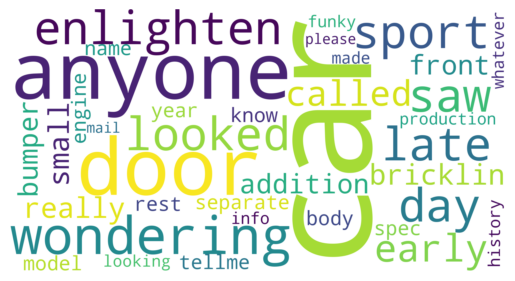

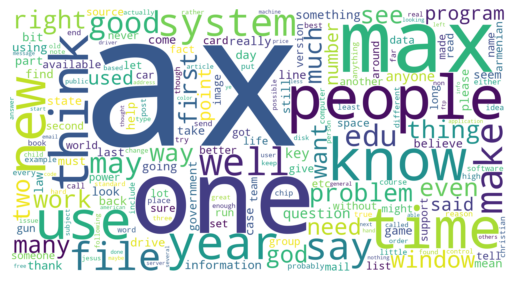

In [6]:
word_cloud1 = WordCloud(collocations = False, background_color = 'white', width = 2048, height = 1080).generate(train_docs[0])
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

# Para todos los elementos del dataset de entrenamiento.
corpus_mixed = train_docs[0]
for doc in train_docs[1:]:
    corpus_mixed += ' ' + doc
word_cloud2 = WordCloud(collocations = False, background_color = 'white', width = 2048, height = 1080).generate(corpus_mixed)
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
esBigrams = ngrams(corpus_mixed.split(), 2)
esBigramFreq = collections.Counter(esBigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(10)

[(("'ax", "'ax"), 56158),
 (('max', "'ax"), 4340),
 (("'ax", 'max'), 4306),
 (('would', 'like'), 429),
 (('united', 'state'), 301),
 (('anyone', 'know'), 294),
 (('new', 'york'), 284),
 (('year', 'ago'), 260),
 (('last', 'year'), 258),
 (('thanks', 'advance'), 236)]

Visualiza los 10 bigramas más comunes del corpus

**RESPUESTA**:

¿Qué bigramas y palabras son más comunes en el corpus? ¿Aparece algo raro? HINT: Pueden aparecer elementos que parecieran palabras pero no lo son

**RESPUESTA**:

Las palabras más comunes son aquellas mostradas arriba. Destaca 'ax', la cual no es una palabra. 

Explique para que se utiliza Lemmatizer, tokenizer y stopwords.

**RESPUESTA**:

Cada uno cumple un rol en la regularización del texto a un formato más sencillo, que condensa la información. 

* `Lemmatizer` se encarga de convertir palabras en formas conjugadas a su raíz. De esta manera, se unifican las variaciones de una misma palabra.
* `Stop words` son palabras altamente frecuentes en el lenguaje, que generalmente no aportan significado relevante al entendimiento de un texto.
*  `Tokenizer` se encarga de convertir las palabras en subunidades más pequeñas, que permitan reconstruir las palabras.

## 1.2 Nela Features (5 puntos)

Extraiga características utilizando NELA. Basta con que ocupe una de las características y NO puede utilizar extract_styles. Hint: Recordar que si largo del documento es 0, entonces debe generar un vector del tamaño de las características que vaya a utilizar. 

EJEMPLO: Cuando se utilizaba nela.extract_style se extraen 50 features y por lo tanto se tienen vectores de tamaño 50. Si el largo del documento es 0, no se puede extraer las características (porque no hay documento) y por lo tanto se debe generar un vector del mismo tamaño (50 en este caso) rellenado de 0. Este vector lo pueden llamar como 'vector cero' o 'vector nulo'.

**RESPUESTA**:

In [9]:
nela = NELAFeatureExtractor()
vec, names = nela.extract_bias(train_docs[0])

In [10]:
nela = NELAFeatureExtractor()
feature_vectors_train = []
feature_names_train = []
feature_vectors_test = []
feature_names_test = []

zeros = np.zeros(8)

for doc in train_docs:
    if len(doc) != 0:
        vec, names = nela.extract_bias(doc)
        feature_vectors_train.append(vec)
        feature_names_train.append(names) 
    else:
        feature_vectors_train.append(zeros)
        feature_names_train.append("ceros") 

feature_matrix_train = np.array(feature_vectors_train)

feature_vectors_test = []
feature_names_test = []

for doc in test_docs:
    if len(doc) != 0:
        vec, names = nela.extract_bias(doc)
        feature_vectors_test.append(vec)
        feature_names_test.append(names) 
    else:
        feature_vectors_test.append(zeros)
        feature_names_test.append("ceros")

feature_matrix_test = np.array(feature_vectors_test)


In [11]:
clf = MultinomialNB()
clf.fit(feature_matrix_train, Y_train)
preds = clf.predict(feature_matrix_test)
clf.score(feature_matrix_test, Y_test)

0.08364312267657993

Utilice la matriz de confusión para evaluar el rendimiento del modelo. Es una buena forma de visualizar el desempeño

**RESPUESTA**:


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [14]:
classes_20newsgroups = [
    "alt.atheism",
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
    "rec.sport.baseball",
    "rec.sport.hockey",
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns",
    "talk.politics.mideast",
    "talk.politics.misc",
    "talk.religion.misc"
]


Normalized confusion matrix


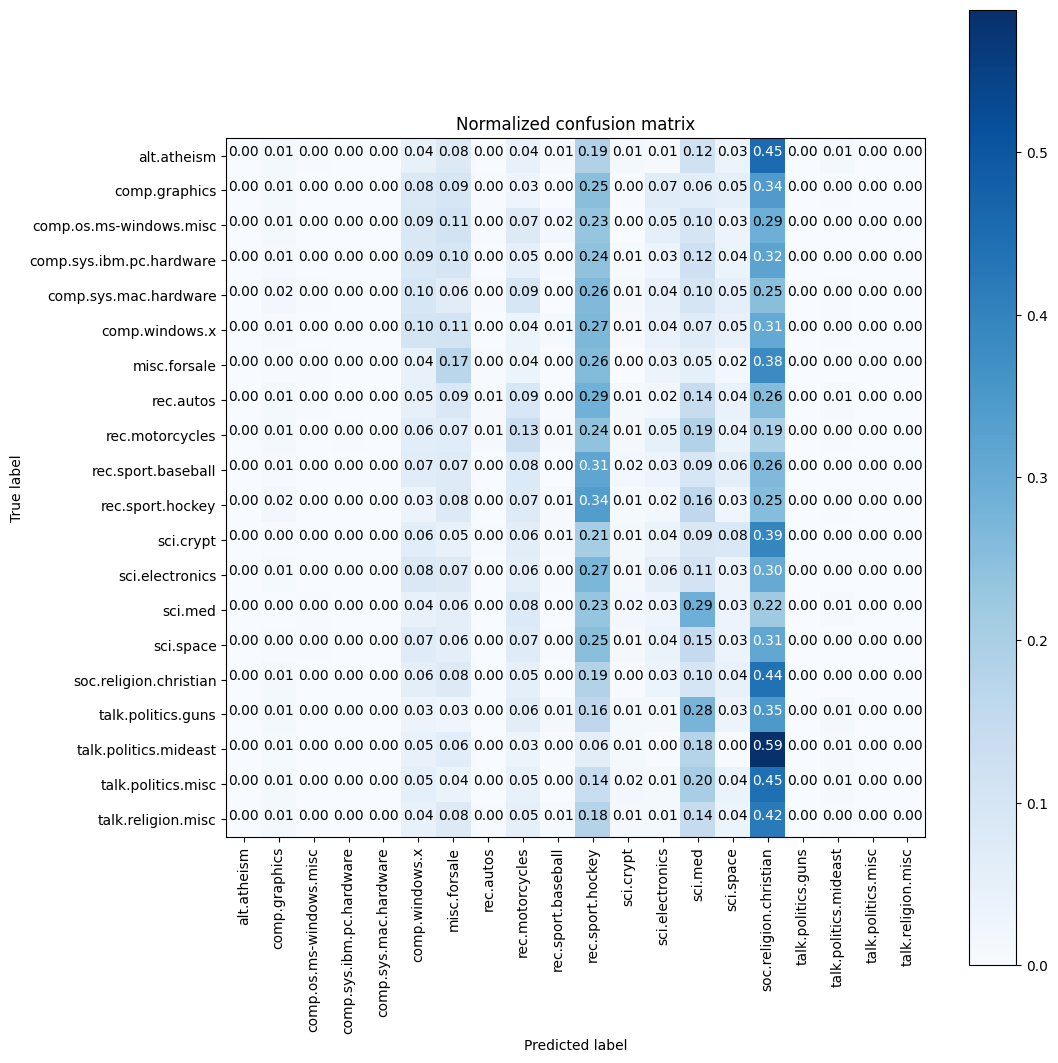

In [15]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(Y_test, preds)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=classes_20newsgroups, normalize=True, title='Normalized confusion matrix')

plt.show()

In [52]:
np.sum(cnf_matrix, axis=0)

array([309, 409, 357, 369, 339, 339, 456, 373, 437, 646, 400, 316, 429,
       416, 424, 475, 440, 342, 198,  58])

¿Qué ocurre con el modelo? ¿Funciona bien o mal? ¿Qué está tratando de hacer con los datos y cuál es su objetivo? Fundamente

**RESPUESTA**:

El modelo presenta un desempeño deficiente. En una matriz de confusión ideal, la diagonal debería acercarse a 1, indicando predicciones correctas para cada clase. Sin embargo, los resultados muestran un sesgo significativo y un bajo rendimiento general, con clasificaciones incorrectas en la mayoría de las clases. En particular, se observa un claro sesgoa clasificar los documentos como relacionados al cristianismo.

¿Cómo se compara con el resultado obtenido en la AF2? (puede revisar el github, donde se encontrarán las soluciones de las actividades formativas)

**RESPUESTA**:

Ambos modelos funcionan terriblemente. Sin embargo, el modelo de la actividad formativa tiene un score de 0.11, mientras que el mostrado anteriormente es de 0.08. Es decir, el nuestro funciona un poco peor que el de la AF. Al comparar matrices de confusión se observa que ambos modelos tienen un sesgo, donde tienden a clasificar gran parte de las noticias de cualquier tipo como cristianas.

¿Qué se podría realizar para mejorar la precisión del modelo?

**RESPUESTA**:

Hay varias opciones: quizá los datos están desbalanceados. En tal caso, lo conveniente sería ampliar los datos de entrenamiento tal que no haya una sobrerrepresentación de clases. Otra opción sería cambiar el modelo.es posible que Naive Bayes no sea capaz de abarcar la complejidad de las relaciones, o el supuesto de independencia se rompa con demasiada fuerza. Finalmente, quizá el problema se relaciona con como estamos tokenizando , lematizando y vectorizando la información. Probar otras estrategias puede ser clave.

## 1.3: TF-IDF (5 puntos)

Dado que es posible que haya malos resultados, se probará otra forma de entrenar y clasificar estos textos. Utilice un modelo TF-IDF para representar los documentos

Separe la data en X_train, y_train, X_test e y_test

**RESPUESTA**:

In [28]:
X_train, Y_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'), return_X_y=True)
X_test, Y_test  = fetch_20newsgroups(subset="test", remove=('headers', 'footers', 'quotes'), return_X_y=True)

Utilice TfidfVectorizer para transformar los textos en vectores TF-IDF.

Utilice la librería make_pipeline de sklearn que incluye el TfidfVectorizer y el clasificador que desee utilizar (por ejemplo, SGDClassifier o LogisticRegression).


**RESPUESTA**:

In [47]:
from sklearn.linear_model import SGDClassifier
model = make_pipeline(
    TfidfVectorizer(),
    SGDClassifier(loss='log_loss', random_state=3670)
)
model.fit(X_train, Y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('sgdclassifier',
                 SGDClassifier(loss='log_loss', random_state=3670))])

In [50]:
# scores and predictions
print("score LogisReg:", model.score(X_test, Y_test))
preds = model.predict(X_test)

score LogisReg: 0.676048858204992


Normalized confusion matrix


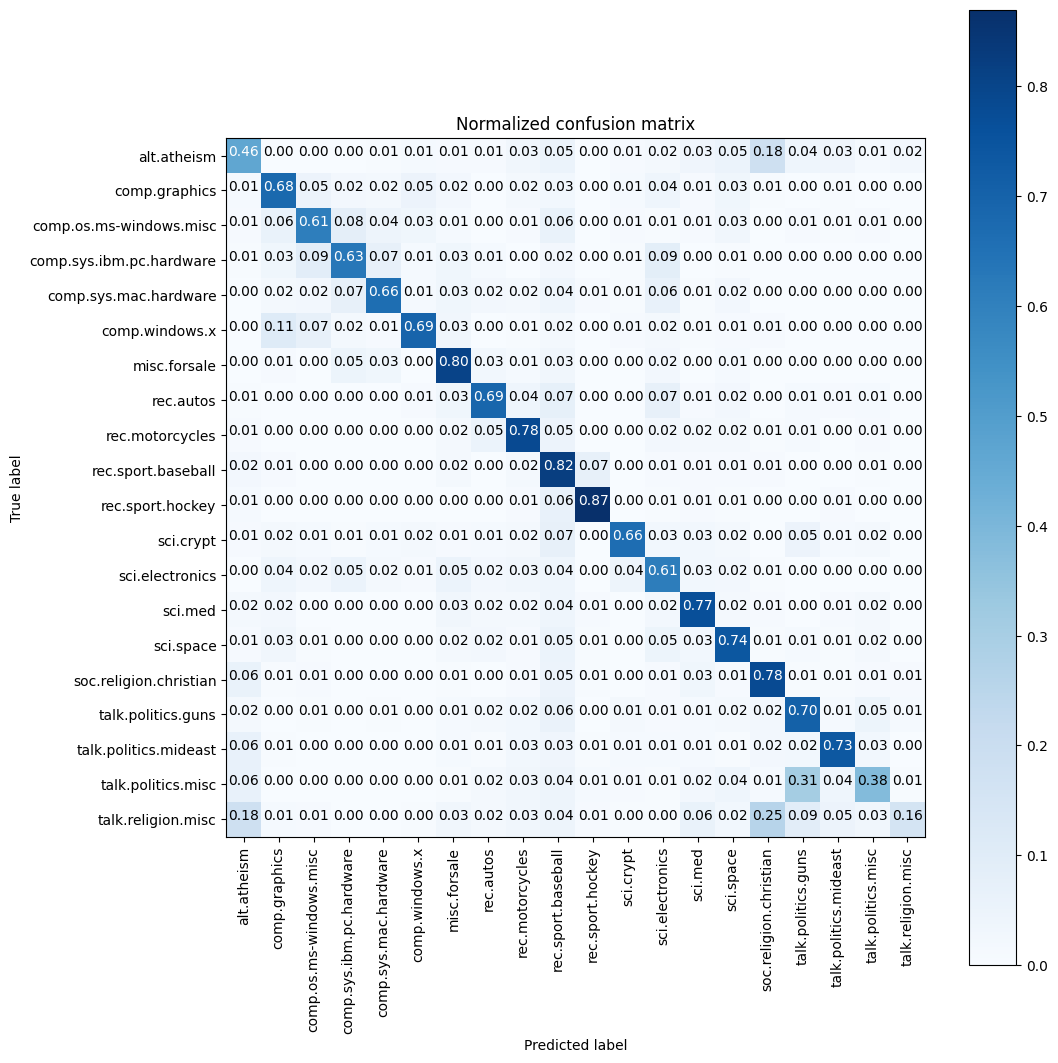

In [49]:
cnf_matrix = confusion_matrix(Y_test, preds)
np.set_printoptions(precision=2)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=classes_20newsgroups, normalize=True, title='Normalized confusion matrix')

plt.show()

In [42]:
# Para comparar, usemos naive Bayes de nuevo, pero con el TfidfVectorizer
model_NB = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)
model_NB.fit(X_train, Y_train)
# scores and predictions
print("score:", model_NB.score(X_test, Y_test))
preds_NB = model_NB.predict(X_test)

score: 0.6062134891131173


Normalized confusion matrix


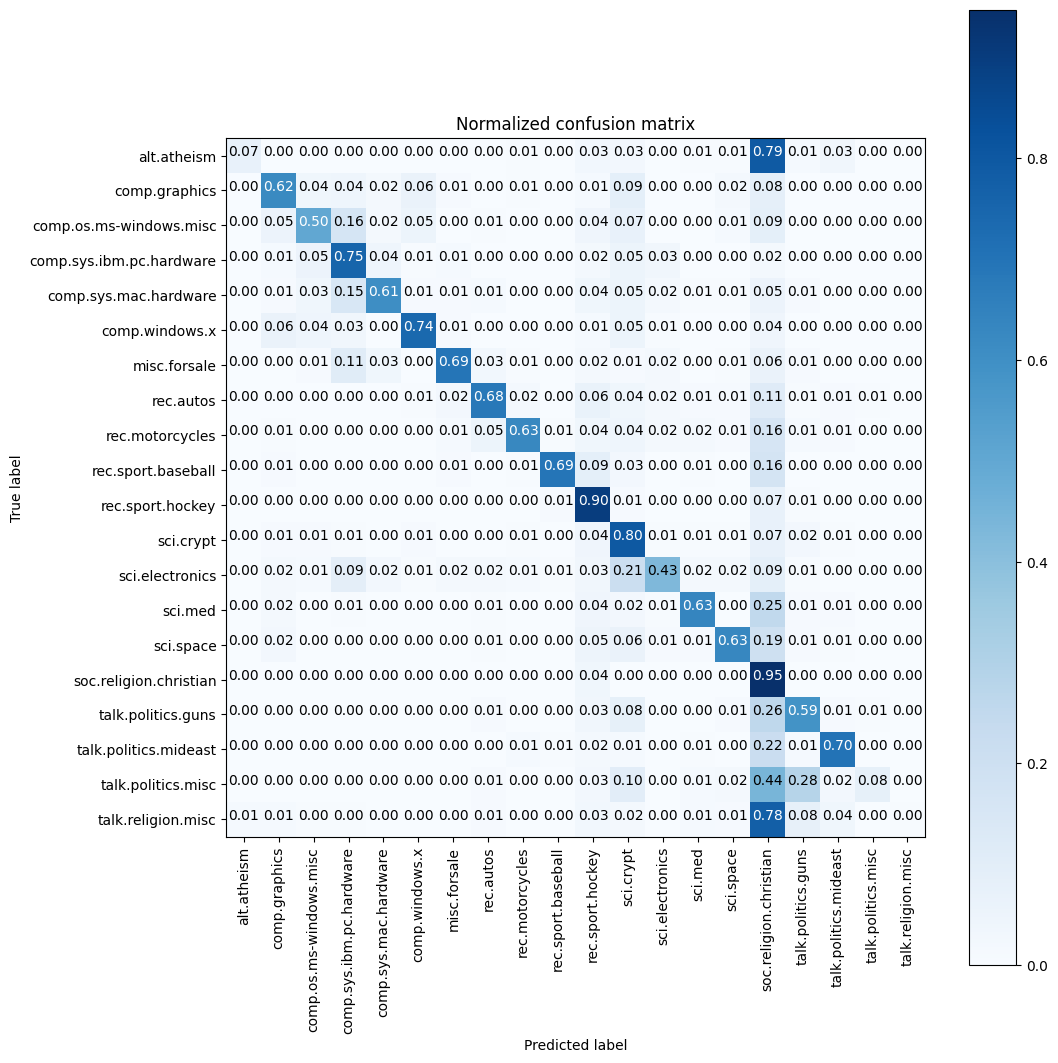

In [43]:
cnf_matrix = confusion_matrix(Y_test, preds)
np.set_printoptions(precision=2)
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=classes_20newsgroups, normalize=True, title='Normalized confusion matrix')

plt.show()

**RESPUESTA**:

¿Por qué cambió los resultados? 

**RESPUESTA**:

En comparativa con el primer modelo, se relaizaron dos cambios significativos: se cambió Naive Bayes por Regresión Logistica y se vectorizaron los datos mediante TF-IDF. Con la finalidad de analizar el impacto de la nueva vectorización, se entrenó un Naive bayes con vectorización TF-IDF.


Los resultados son claros: el score obtenido al modificar únicamente la vectorización presenta una mejora brutal, alcanzando un valor de 0.6, cotnra 0.08 obtenido originalmente. Así mismo, se observa en la matriz de confusión que la diagonal concentra la gran mayoría del valor, indicando que se está clasificando de forma más acertada. Las únicas excepciones son la primera y las dos últimas clases. La primera clase confunde atletismo con religión, mientras que las dos últimas, política y religión respectivamente, se confunden con cristianismo. 


Finalmente, al utilizar la vectorización TF-IDF y la regresión logística, se observa una mejora del score, alcanzando 0.676, 7.6 puntos sobre Naive bayes con TF-IDF. Se observa también que la matriz de confusión no presenta cofusiones tan significativas como en el caso anterior.

# Parte 2: Word2Vec (20 puntos)

### 2.1 Teóricas (5 puntos)

Para resolver las preguntas deberá utilizar la siguiente página: https://projector.tensorflow.org

En la página entregada anteriormente, use el tensor 'Word2Vec 10k', busque la palabra 'learning' con 20 vecinos y anote las 3 palabras más parecidas y las 3 más alejadas, dejando claramente a que categoría pertenece y dejando los valores correspondiente al usar la distancia del coseno. Para la reducción de dimensionalidad, mantenga el uso de PCA.

**RESPUESTA**:

¿Qué mide la distancia del coseno y que relación hay con la similitud del coseno?

**RESPUESTA**:

Explique la relación de los valores obtenidos anteriormente con las palabras encontradas

**RESPUESTA**:

## 2.2 Análisis de Dataset (5 puntos)

El archivo de canvas (Dataset) proviene de: https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish

¿Qué contiene el dataset?

**RESPUESTA**:

¿Cuántas filas tiene el dataset?

**RESPUESTA**:

Vea la distribución del número de palabras mediante un gráfico

**RESPUESTA**:

Crea una nube de palabras para el dataset mostrando las palabras más frecuentes en el texto. Primero utilice para el corpus la concatenación de todos los textos de la columna "review_es" y luego realice tokenización y genere otra nube de palabras.

**RESPUESTA**:

## 2.3 Transformación a Embeddings (5 puntos)

Transforme los reviews en español a vectores (embeddings)

**RESPUESTA**:

## 2.4 Generación de gráficos (5 puntos)

Utilice PCA con 3 componentes sobre los embeddings

**RESPUESTA**:

Realizando lo anterior, se podría considerar como puntos en 3D y nos permite visualizar en el espacio. Realice una visualización de los puntos en 3D, coloreando cada clase.

**RESPUESTA**:

Utilice t-SNE y vuelva realizar el gráfico

**RESPUESTA**:

¿Qué se puede concluir con las visualizaciones realizadas por las dos reducciones de dimensionalidad? 

**RESPUESTA**:

¿Qué limitaciones tiene utilizar reducción de dimensionalidad en los embeddings? ¿Los usaría para entrenar?

**RESPUESTA**:

# Parte 3: Análisis de Sentimiento (25 puntos)

### Parte 3.1: Pruebas de Análisis de Sentimiento (4 puntos)

Usar la librería de Textblob para la actividad.

Cargue el dataset proveniente de: https://huggingface.co/datasets/mltrev23/financial-sentiment-analysis/blob/main/archive.zip

**RESPUESTA**:

Escoja dos documentos y utilice TextBlob sobre ellos.
Métodos a utilizar: tags, sentiment, polarity, subjectivity y words

**RESPUESTA**:

¿Qué es lo que señala TextBlob en los documentos seleccionados? ¿Funciona correctamente? Justifique. Hint: Para ver si funciona correctamente compare los resultados obtenidos con los labels del dataset y si la Sentence es acorde a los resultados obtenidos

**RESPUESTA**:

Pruebe utilizando TextBlob con la frase de Beneditti ‘De qué sirve querer olvidar, a veces simplemente se trata de aprender a vivir con eso’. Luego pruebe la segunda frase 'La vida es una lucha constante'. Justifique los resultados.

**RESPUESTA**:

¿Qué haría usted para mejorar la clasificación de análisis de sentimiento para el idioma Español pero dando prioridad a como hablamos los chilenos?

**RESPUESTA**:

¿Podría haber problemas al realizar el análisis de sentimiento para un español generalizado y en particular con insultos? Explique

**RESPUESTA**:

#### Lectura Opcional: Hay una librería llamada `vaderSentiment` que puede ser útil para el análisis de sentimientos. Además hay otro paquete que permite analizar el sentimiento en varios idiomas llamado `vader-multi`.
https://github.com/brunneis/vader-multi

### Parte 3.2: Clasificación de análisis de sentimiento con Word2Vec (9 puntos)

Haga un procesamiento de los datos (Sentences)

**RESPUESTA**:

Guarde los labels en una variable y

**RESPUESTA**:

Transforme el texto a embeddings. Probablemente necesites tener vectores de tamaño fijo, así que considera usar un enfoque como padding o truncamiento.

**RESPUESTA**:

Divida los datos en conjuntos de entrenamiento y prueba. Además crea un array de índices para utilizar en el train_test_split. Es importante para utilizar en el LimeExplainer después.

**RESPUESTA**:

Utilice el modelo (SGD  o regresión logística) para clasificar las 3 clases y muestre la matriz de confusión

**RESPUESTA**:

Utilice LimeTextExplainer para interpretar las predicciones de su modelo. Esto le permitirá entender qué palabras o frases están influyendo más en las decisiones del clasificador.

HINT: Cree una funcion que reciba los textos, use el tokenize y agregalos en una lista. Luego utilice el modelo para predecir sobre la lista de los embeddings. LimeTextExplainer necesita una función que reciba los textos. 

**RESPUESTA**:

¿Los resultados fueron buenos o malos? Fundamente

**RESPUESTA:**

¿Cómo mejoraría el modelo? 

**RESPUESTA:**

### Parte 3.3: Clasificación de análisis de sentimiento con GloVe (12 puntos)

Muestre los modelos que contiene gensim (código de clases o formativa)

**RESPUESTA**:

Cargue algunos de los modelos anteriores (ej: glove-wiki-gigaword-50)

**RESPUESTA**:

Transforme el texto a embeddings utilizando GloVe

**RESPUESTA**:

Crear un MLP que clasifique entre las 3 clases. Recordar lo utilizado para LimeText.

**RESPUESTA**:

Utilice LimeTextExplainer para interpretar las predicciones de su modelo.

**RESPUESTA**:

¿Por qué es mejor este último clasificador? 

**RESPUESTA**: